In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

In [3]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

Quantum node
============

For a single quantum mode, each layer of the variational circuit is
defined as:


In [4]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into
the displacement of the mode, and then executes the layers. The output
is the expectation of the x-quadrature.


In [5]:
@qml.qnode(dev)
def quantum_neural_net(var, x):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

Objective
=========

As an objective we take the square loss between target labels and model
predictions.


In [6]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In the cost function, we compute the outputs from the variational
circuit. Function fitting is a regression problem, and we interpret the
expectations from the quantum node as predictions (i.e., without
applying postprocessing such as thresholding).


In [7]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x) for x in features]
    return square_loss(labels, preds)

Optimization
============

We load noisy data samples of a sine function from the external file
`sine.txt`
(`<a href="https://raw.githubusercontent.com/XanaduAI/pennylane/v0.3.0/examples/data/sine.txt"
download="sine.txt" target="_blank">download the file here</a>`{.interpreted-text
role="html"}).


In [8]:
X = np.linspace(-1,1,num=50, requires_grad=False)
Y = np.sin(3*X, requires_grad=False)
Y

tensor([-0.14112001, -0.26098424, -0.37694022, -0.48725151, -0.59026619,
        -0.68444163, -0.76836753, -0.84078711, -0.90061587, -0.94695789,
        -0.97911919, -0.99661815, -0.99919273, -0.98680437, -0.95963858,
        -0.91810218, -0.86281718, -0.79461147, -0.71450642, -0.62370163,
        -0.52355688, -0.41557185, -0.30136363, -0.18264248, -0.06118625,
         0.06118625,  0.18264248,  0.30136363,  0.41557185,  0.52355688,
         0.62370163,  0.71450642,  0.79461147,  0.86281718,  0.91810218,
         0.95963858,  0.98680437,  0.99919273,  0.99661815,  0.97911919,
         0.94695789,  0.90061587,  0.84078711,  0.76836753,  0.68444163,
         0.59026619,  0.48725151,  0.37694022,  0.26098424,  0.14112001], requires_grad=False)

Before training a model, let\'s examine the data.

*Note: For the next cell to work you need the matplotlib library.*


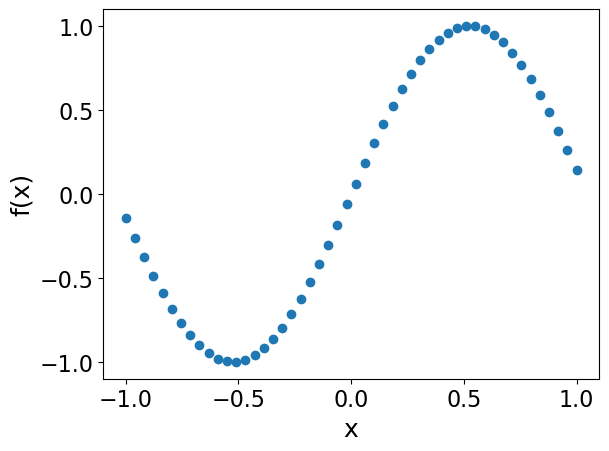

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X, Y)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.show()

![image](../demonstrations/quantum_neural_net/qnn_output_20_0.png)

The network's weights (called `var` here) are initialized with values
sampled from a normal distribution. We use 4 layers; performance has
been found to plateau at around 6 layers.


In [10]:
np.random.seed(0)
num_layers = 4
var_init = 0.05 * np.random.randn(num_layers, 5, requires_grad=True)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]]


::: {.rst-class}
sphx-glr-script-out

Out:

``` {.none}
array([[ 0.08820262,  0.02000786,  0.0489369 ,  0.11204466,  0.0933779 ],
       [-0.04886389,  0.04750442, -0.00756786, -0.00516094,  0.02052993],
       [ 0.00720218,  0.07271368,  0.03805189,  0.00608375,  0.02219316],
       [ 0.01668372,  0.07470395, -0.01025791,  0.01565339, -0.04270479]])
```
:::

Using the Adam optimizer, we update the weights for 500 steps (this
takes some time). More steps will lead to a better fit.


In [11]:
def Normalizar(lista):
    maxl = np.max(lista)
    minl = np.min(lista)
    return (2/(maxl-minl))*lista + (maxl+minl)/(minl-maxl) 

datos = np.array([34980317, 35363890, 35750033, 36127525, 36506811, 36868100, 37194315, 37493072, 37764458, 37987108, 38160263, 38325244, 38467025, 38571941, 38682322, 38764307, 38821377, 38860827,
                    38941622, 39147940, 39356082, 39547353, 39718895, 39884246, 40049974, 40214066, 40369667, 40554387, 40766049, 41423520, 42196231, 42859172, 43662613, 44360521, 45236004, 45983169,
                    46367550, 46562483, 46736257, 46766403, 46593236, 46455123, 46410149, 46449874, 46532869, 46728814, 47105358, 47355685, 47331302, 47615034],requires_grad=False)

tiempo = np.arange(1973, 1973+datos.size, requires_grad=False)

datos_normalizado = Normalizar(datos)
tiempo_normalizado = Normalizar(tiempo)

In [12]:
tiempo_normalizado

tensor([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
        -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
        -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
        -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
        -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
         0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
         0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.3877551 ,
         0.42857143,  0.46938776,  0.51020408,  0.55102041,  0.59183673,
         0.63265306,  0.67346939,  0.71428571,  0.75510204,  0.79591837,
         0.83673469,  0.87755102,  0.91836735,  0.95918367,  1.        ], requires_grad=False)

In [17]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(500):
    (var, _, _), _cost = opt.step_and_cost(cost, var, tiempo_normalizado, datos_normalizado)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it, _cost))

Iter:     0 | Cost: 0.1376298 
Iter:     1 | Cost: 0.0596256 
Iter:     2 | Cost: 0.0233231 
Iter:     3 | Cost: 0.0358828 
Iter:     4 | Cost: 0.0549603 
Iter:     5 | Cost: 0.0519558 
Iter:     6 | Cost: 0.0389200 
Iter:     7 | Cost: 0.0281612 
Iter:     8 | Cost: 0.0238859 
Iter:     9 | Cost: 0.0245452 
Iter:    10 | Cost: 0.0270638 
Iter:    11 | Cost: 0.0292602 
Iter:    12 | Cost: 0.0300908 
Iter:    13 | Cost: 0.0292727 
Iter:    14 | Cost: 0.0270852 
Iter:    15 | Cost: 0.0242595 
Iter:    16 | Cost: 0.0217480 
Iter:    17 | Cost: 0.0203551 
Iter:    18 | Cost: 0.0203695 
Iter:    19 | Cost: 0.0214116 
Iter:    20 | Cost: 0.0226561 
Iter:    21 | Cost: 0.0233247 
Iter:    22 | Cost: 0.0230995 
Iter:    23 | Cost: 0.0221831 
Iter:    24 | Cost: 0.0210536 
Iter:    25 | Cost: 0.0201552 
Iter:    26 | Cost: 0.0197153 
Iter:    27 | Cost: 0.0197285 
Iter:    28 | Cost: 0.0200387 
Iter:    29 | Cost: 0.0204371 
Iter:    30 | Cost: 0.0207361 
Iter:    31 | Cost: 0.0208137 
Iter:   

Iter:   265 | Cost: 0.0161465 
Iter:   266 | Cost: 0.0161415 
Iter:   267 | Cost: 0.0161366 
Iter:   268 | Cost: 0.0161317 
Iter:   269 | Cost: 0.0161267 
Iter:   270 | Cost: 0.0161218 
Iter:   271 | Cost: 0.0161169 
Iter:   272 | Cost: 0.0161120 
Iter:   273 | Cost: 0.0161071 
Iter:   274 | Cost: 0.0161022 
Iter:   275 | Cost: 0.0160973 
Iter:   276 | Cost: 0.0160924 
Iter:   277 | Cost: 0.0160875 
Iter:   278 | Cost: 0.0160826 
Iter:   279 | Cost: 0.0160777 
Iter:   280 | Cost: 0.0160728 
Iter:   281 | Cost: 0.0160679 
Iter:   282 | Cost: 0.0160630 
Iter:   283 | Cost: 0.0160581 
Iter:   284 | Cost: 0.0160532 
Iter:   285 | Cost: 0.0160483 
Iter:   286 | Cost: 0.0160434 
Iter:   287 | Cost: 0.0160385 
Iter:   288 | Cost: 0.0160336 
Iter:   289 | Cost: 0.0160287 
Iter:   290 | Cost: 0.0160238 
Iter:   291 | Cost: 0.0160189 
Iter:   292 | Cost: 0.0160139 
Iter:   293 | Cost: 0.0160090 
Iter:   294 | Cost: 0.0160041 
Iter:   295 | Cost: 0.0159992 
Iter:   296 | Cost: 0.0159942 
Iter:   

In [14]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x_) for x_ in x_pred]

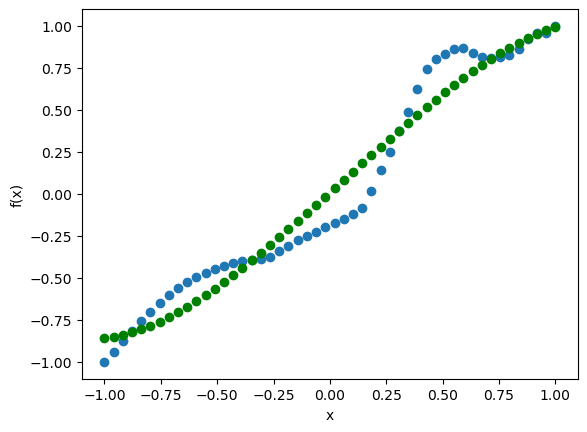

In [15]:
plt.figure()
plt.scatter(tiempo_normalizado, datos_normalizado)
plt.scatter(x_pred, predictions, color="green")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

![image](../demonstrations/quantum_neural_net/qnn_output_30_0.png)


About the author
================
